In [1]:
%pip install scikit-learn pandas numpy palmerpenguins

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\alexc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


---
---
### Paso 1: Obtención de Datos

En este primer paso se debe encontrar o construir un **dataset** que cumpla con los siguientes requisitos:

#### Características del dataset:

- Debe contener al menos **4 columnas de variables independientes**, incluyendo:
  - Al menos **3 columnas con datos numéricos**.  
    > *Nota:* Al menos **una** de estas columnas debe contener **valores ausentes**.
  - Al menos **1 columna con datos categóricos de tipo ordinal**.

- Debe incluir **1 columna como variable dependiente** (también llamada **etiqueta** o **variable objetivo**), que pueda tomar **exactamente 4 clases** o valores posibles.

#### Salida de este paso:

- **Conjunto de datos** seleccionado o construido que será utilizado a lo largo del proyecto.
- **Cantidad de datos ausentes por columna** en el dataset.


In [2]:
import pandas as pd
import numpy as np

# Configuración
np.random.seed(38)
n_pacientes = 1000

# Datos
data = {
    'Edad': np.random.randint(30, 91, n_pacientes),
    'IMC': np.round(np.random.normal(28, 5, n_pacientes)),
    'Nivel_Glucosa': np.random.randint(70, 351, n_pacientes),  # Ampliado hasta 350
    'Adherencia_Tratamiento': np.random.choice([1, 2, 3, 4], n_pacientes, p=[0.2, 0.3, 0.3, 0.2]),
    'Presión_Arterial': np.random.randint(90, 181, n_pacientes),
    'Días_Hospitalización': np.random.randint(1, 31, n_pacientes),  # Ampliado hasta 30 días
    'Comorbilidades': np.random.randint(0, 6, n_pacientes)
}

# Añadir missings (usando indexación booleana de NumPy)
mask_imc = np.random.random(n_pacientes) < 0.25  # Aumentado a 25% missings en IMC
data['IMC'] = np.where(mask_imc, np.nan, data['IMC'])

mask_glucosa = np.random.random(n_pacientes) < 0.15  # Aumentado a 15% missings en glucosa
data['Nivel_Glucosa'] = np.where(mask_glucosa, np.nan, data['Nivel_Glucosa'])

# Variable objetivo (4 clases) - Condiciones en orden de prioridad
condiciones = [
    # Condición CRÍTICO primero (mayor prioridad)
    (data['Nivel_Glucosa'] > 280) | (np.isnan(data['IMC'])),
    ((data['Comorbilidades'] >= 4) & (data['Días_Hospitalización'] > 20)),
    
    # Condición ALTO (solo si no es crítico)
    (data['Comorbilidades'] > 3) | (data['Días_Hospitalización'] > 15),
    
    # Condición BAJO (solo si no es crítico ni alto)
    (data['Comorbilidades'] <= 1) & (data['Días_Hospitalización'] <= 5),
    
    # MODERADO por defecto (si no cumple ninguna de las anteriores)
]

clases = ['Crítico', 'Alto', 'Bajo', 'Moderado']
data['Riesgo_Reingreso'] = np.select(condiciones, clases, default='Moderado')

# Convertir a DataFrame de pandas
df_final = pd.DataFrame(data)

# Verificación final
print("\nDistribución de clases de riesgo:")
print(df_final['Riesgo_Reingreso'].value_counts())

print("\nPrimeras filas del dataset:")
print(df_final.head())
print("\nDatos ausentes por columna:")
print(df_final.isnull().sum())

# Guardar a CSV
df_final.to_csv("dataset_pacientes_prioridad_correcta_(autogenerado).csv", index=False)


Distribución de clases de riesgo:
Riesgo_Reingreso
Crítico     417
Bajo        325
Moderado    192
Alto         66
Name: count, dtype: int64

Primeras filas del dataset:
   Edad   IMC  Nivel_Glucosa  Adherencia_Tratamiento  Presión_Arterial  \
0    63  24.0          120.0                       2                91   
1    41   NaN            NaN                       2               110   
2    83  32.0          102.0                       3               136   
3    49  33.0          307.0                       2               124   
4    90  24.0            NaN                       1               123   

   Días_Hospitalización  Comorbilidades Riesgo_Reingreso  
0                    25               5             Alto  
1                    21               2          Crítico  
2                    29               4             Alto  
3                    28               4          Crítico  
4                    29               5             Alto  

Datos ausentes por columna:
E

---
---
### Paso 2: Preprocesamiento de Datos

En este paso se aplicarán técnicas de **preprocesamiento** sobre el dataset original para dejarlo listo para la construcción y validación de los modelos.

#### Tratamientos a aplicar:

- **Gestión de datos ausentes:**  
  Se deberán tratar los valores faltantes de forma razonada, considerando el contexto del negocio que representan.  
  > *Importante:* No se permitirá la eliminación de filas o columnas que contengan valores ausentes.

- **Gestión de variables categóricas ordinales:**  
  Se utilizará la técnica de **Ordinal Encoding** para transformar este tipo de variables en valores numéricos ordenados.

- **División de datos:**  
  El conjunto de datos se dividirá en:
  - **75%** para **entrenamiento**.
  - **25%** para **validación**.

- **Normalización de variables independientes:**  
  Se normalizarán todas las **variables independientes**, incluyendo las generadas tras la transformación de variables categóricas.

#### Salida de este paso:

- **Conjunto de datos de entrenamiento normalizados.**
- **Cantidad de datos ausentes por columna** en el conjunto de entrenamiento.
- **Conjunto de datos de prueba normalizados.**
- **Cantidad de datos ausentes por columna** en el conjunto de prueba.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# --------------------------
# Gestión de datos ausentes
# --------------------------

# Estrategias de imputación basadas en el contexto del negocio
imputer_strategies = {
    'IMC': 'mean',        # IMC es una medida continua, usamos la media
    'Nivel_Glucosa': 'median'  # Nivel de glucosa puede tener outliers, usamos mediana
}

# Aplicar imputación
for col, strategy in imputer_strategies.items():
    imputer = SimpleImputer(strategy=strategy)
    df_final[col] = imputer.fit_transform(df_final[[col]])

# --------------------------
# Codificación de variables ordinales
# --------------------------

# Adherencia_Tratamiento es ordinal (1: baja, 4: alta)
# No necesitamos codificarla ya que ya está en formato ordinal correcto

# Variable objetivo (Riesgo_Reingreso) es ordinal y necesitamos codificarla
risk_order = ['Bajo', 'Moderado', 'Alto', 'Crítico']
ordinal_encoder = OrdinalEncoder(categories=[risk_order])
df_final['Riesgo_Reingreso_encoded'] = ordinal_encoder.fit_transform(df_final[['Riesgo_Reingreso']])

# --------------------------
# División en train y test
# --------------------------

# Variables independientes (todas excepto la objetivo)
X = df_final.drop(['Riesgo_Reingreso', 'Riesgo_Reingreso_encoded'], axis=1)
# Variable objetivo codificada
y = df_final['Riesgo_Reingreso_encoded']

# Dividir 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=38, stratify=y
)

# --------------------------
# Normalización de datos
# --------------------------

# Seleccionar todas las columnas numéricas para normalizar
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Crear y ajustar el scaler con los datos de entrenamiento
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# Aplicar la misma transformación a los datos de test
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# --------------------------
# Resultados
# --------------------------

print("\nConjunto de datos de entrenamiento normalizados (primeras 5 filas):")
print(X_train.head())
print("\nCantidad de datos ausentes por columna en entrenamiento:")
print(X_train.isnull().sum())

print("\nConjunto de datos de prueba normalizados (primeras 5 filas):")
print(X_test.head())
print("\nCantidad de datos ausentes por columna en prueba:")
print(X_test.isnull().sum())



Conjunto de datos de entrenamiento normalizados (primeras 5 filas):
     Edad       IMC  Nivel_Glucosa  Adherencia_Tratamiento  Presión_Arterial  \
890    82  0.528990       0.842857                0.000000               174   
113    63  0.558824       0.778571                0.666667               110   
881    84  0.882353       0.839286                0.333333               170   
955    72  0.647059       0.078571                0.000000               144   
188    67  0.528990       0.532143                0.000000               166   

     Días_Hospitalización  Comorbilidades  
890                    14               0  
113                    24               0  
881                     8               3  
955                     8               2  
188                    11               1  

Cantidad de datos ausentes por columna en entrenamiento:
Edad                      0
IMC                       0
Nivel_Glucosa             0
Adherencia_Tratamiento    0
Presión_Arterial

---
---
### Paso 3: Generación de los Modelos Iniciales

En este paso se generarán **6 modelos de clasificación** utilizando diferentes técnicas. Todos los modelos se entrenarán con el conjunto de datos de entrenamiento y se evaluarán con el conjunto de prueba.

#### Modelos a generar:

1. **Regresión Logística**  
   - Utilizando todas las columnas como variables independientes.

2. **Máquinas de Vectores Soporte (SVM) con Kernel Lineal**  
   - Usando todas las columnas.  
   - Parámetro de regularización: `C = 50`.

3. **SVM con Kernel RBF**  
   - Usando todas las columnas.  
   - Parámetro de regularización: `C = 50`.

4. **K Vecinos más Cercanos (KNN)**  
   - Usando todas las columnas.  
   - Número de vecinos: `K = 3`.  
   - Distancia: Euclidiana.

5. **Árbol de Decisión**  
   - Parámetros por defecto o adaptados según sea necesario.

6. **Bosque Aleatorio (Random Forest)**  
   - Máximo de árboles: `10`.  
   - Criterio de división: `Gini`.  
   - Profundidad máxima: `4`.  
   - Máximo de 1/3 de las filas utilizadas para entrenar cada árbol.

#### Evaluación de los modelos:

A cada modelo se le aplicarán los datos de prueba y se recogerán las siguientes métricas de desempeño:

- Matriz de Confusión  
- Exactitud (Accuracy)  
- Precisión (Precision)  
- Sensibilidad (Recall)  
- F1 Score

#### Salida de este paso:

Una tabla resumen que contenga, para **cada uno de los 6 modelos**, los siguientes resultados:

- Matriz de Confusión  
- Exactitud  
- Precisión  
- Sensibilidad  
- F1 Score


Distribución de clases en y_train:
Riesgo_Reingreso_encoded
0    244
1    144
2     49
3    313
Name: count, dtype: int64

Distribución de clases en y_test:
Riesgo_Reingreso_encoded
0     81
1     48
2     17
3    104
Name: count, dtype: int64

0:Bajo, 1:Moderado, 2:Alto, 3:Crítico

Entrenando Regresión Logística...


C:\Users\alexc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\alexc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Resultados para Regresión Logística ===
Clases presentes: ['Bajo', 'Moderado', 'Alto', 'Crítico']
Exactitud (Accuracy): 0.6280
Precisión (Precision): 0.6296
Sensibilidad (Recall): 0.6280
F1 Score: 0.6269


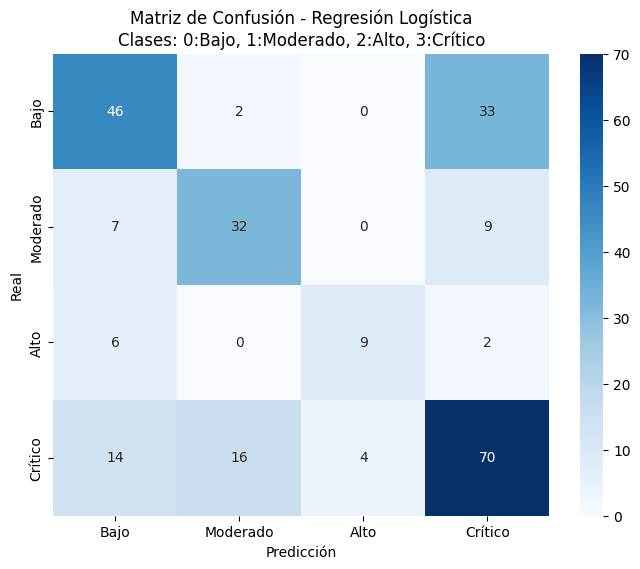


Entrenando SVM Lineal (C=50)...

=== Resultados para SVM Lineal (C=50) ===
Clases presentes: ['Bajo', 'Moderado', 'Alto', 'Crítico']
Exactitud (Accuracy): 0.6240
Precisión (Precision): 0.6255
Sensibilidad (Recall): 0.6240
F1 Score: 0.6231


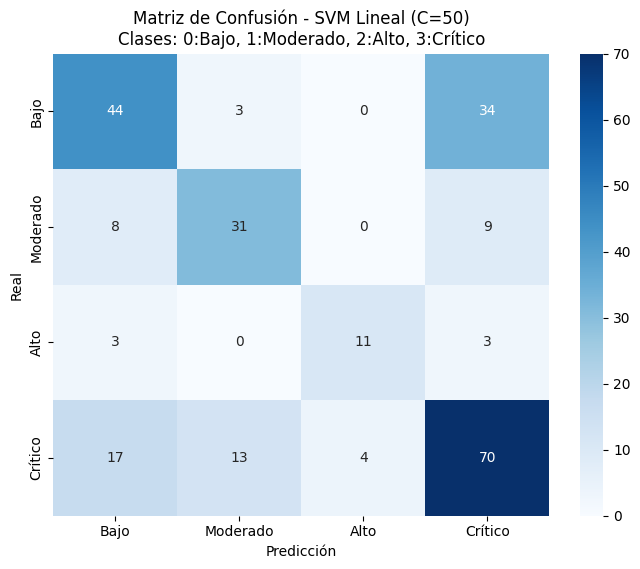


Entrenando SVM RBF (C=50)...

=== Resultados para SVM RBF (C=50) ===
Clases presentes: ['Bajo', 'Moderado', 'Alto', 'Crítico']
Exactitud (Accuracy): 0.4240
Precisión (Precision): 0.4254
Sensibilidad (Recall): 0.4240
F1 Score: 0.3921


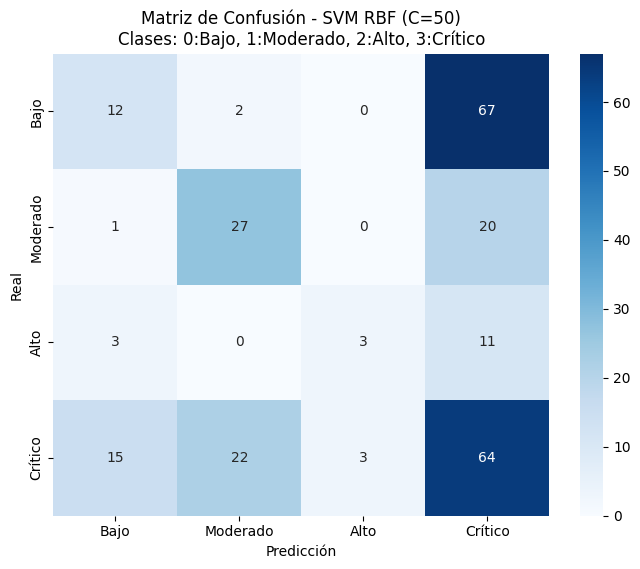


Entrenando KNN (K=3)...

=== Resultados para KNN (K=3) ===
Clases presentes: ['Bajo', 'Moderado', 'Alto', 'Crítico']
Exactitud (Accuracy): 0.3840
Precisión (Precision): 0.3762
Sensibilidad (Recall): 0.3840
F1 Score: 0.3749


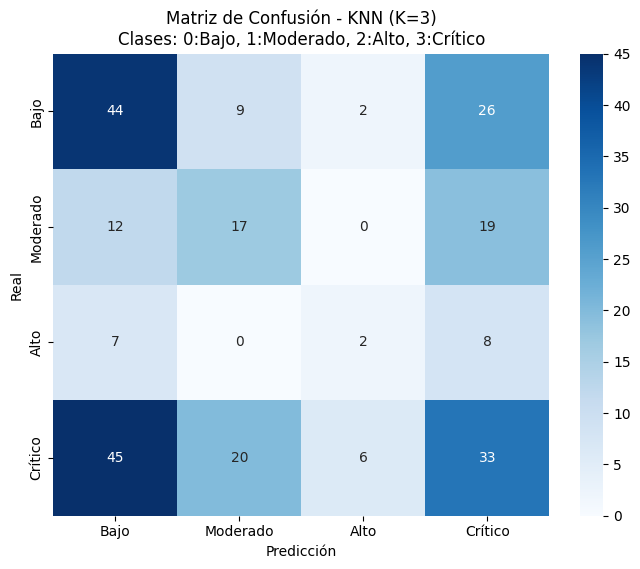


Entrenando Árbol de Decisión...

=== Resultados para Árbol de Decisión ===
Clases presentes: ['Bajo', 'Moderado', 'Alto', 'Crítico']
Exactitud (Accuracy): 1.0000
Precisión (Precision): 1.0000
Sensibilidad (Recall): 1.0000
F1 Score: 1.0000


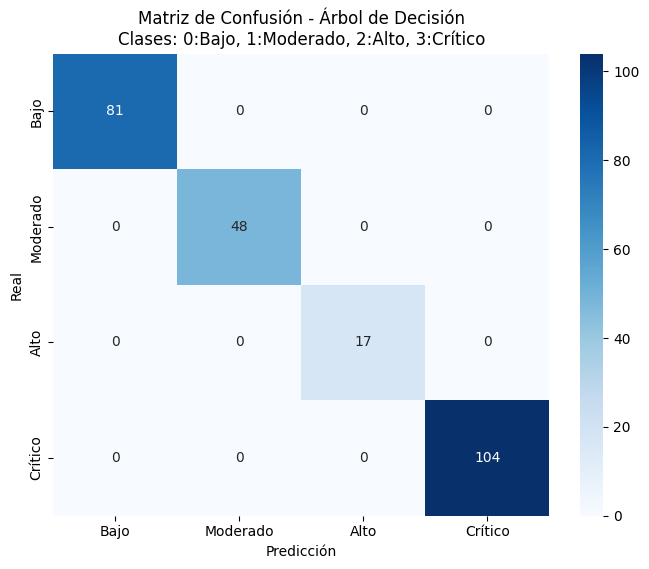


Entrenando Bosque Aleatorio...

=== Resultados para Bosque Aleatorio ===
Clases presentes: ['Bajo', 'Moderado', 'Alto', 'Crítico']
Exactitud (Accuracy): 0.9280
Precisión (Precision): 0.9314
Sensibilidad (Recall): 0.9280
F1 Score: 0.9209


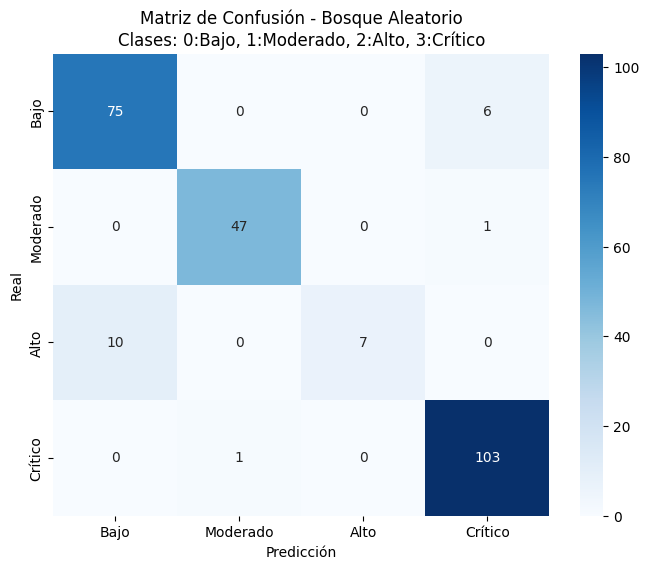


=== Resumen Comparativo de Modelos ===
                Modelo  Accuracy  Precision  Recall        F1
0  Regresión Logística     0.628   0.629560   0.628  0.626902
1    SVM Lineal (C=50)     0.624   0.625539   0.624  0.623135
2       SVM RBF (C=50)     0.424   0.425412   0.424  0.392075
3            KNN (K=3)     0.384   0.376184   0.384  0.374883
4    Árbol de Decisión     1.000   1.000000   1.000  1.000000
5     Bosque Aleatorio     0.928   0.931410   0.928  0.920886

Importancia de características:

Árbol de Decisión:
           Característica  Importancia
1                     IMC     0.410531
2           Nivel_Glucosa     0.218098
6          Comorbilidades     0.209400
5    Días_Hospitalización     0.161971
0                    Edad     0.000000
4        Presión_Arterial     0.000000
3  Adherencia_Tratamiento     0.000000

Bosque Aleatorio:
           Característica  Importancia
2           Nivel_Glucosa     0.257427
1                     IMC     0.251160
5    Días_Hospitalización

In [4]:
# Importación de todas las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

# Configuración de visualización
sns.set_palette('husl')
%matplotlib inline

# 1. Preprocesamiento de datos (repitiendo lo necesario para tener X_train, X_test, y_train, y_test)
# [Aquí iría el código completo de preprocesamiento del Paso 2]

# 2. Asegurar tipos de datos correctos
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Definir orden de clases para visualización
risk_order = ['Bajo', 'Moderado', 'Alto', 'Crítico']

# 3. Función para evaluar modelos (versión corregida)
def evaluate_model(model, X_test, y_test, model_name):
    # Predecir y asegurar que son enteros
    y_pred = model.predict(X_test).astype(int)
    
    # Obtener clases únicas como enteros
    classes = unique_labels(y_test, y_pred).astype(int)
    class_names = [risk_order[i] for i in classes]
    
    # Calcular métricas
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)
    
    # Métricas multiclase
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Mostrar resultados
    print(f"\n=== Resultados para {model_name} ===")
    print(f"Clases presentes: {class_names}")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"Precisión (Precision): {precision:.4f}")
    print(f"Sensibilidad (Recall): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {model_name}\nClases: {", ".join(f"{i}:{name}" for i, name in enumerate(class_names))}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()
    
    return {
        'Modelo': model_name,
        'Matriz_Confusion': conf_matrix,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Clases_Presentes': class_names
    }

# 4. Verificación de distribución de clases
print("Distribución de clases en y_train:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nDistribución de clases en y_test:")
print(pd.Series(y_test).value_counts().sort_index())
print("\n0:Bajo, 1:Moderado, 2:Alto, 3:Crítico")

# 5. Definición y entrenamiento de modelos
models = [
    (LogisticRegression(max_iter=1000, random_state=38, multi_class='multinomial'), "Regresión Logística"),
    (SVC(kernel='linear', C=50, random_state=38, decision_function_shape='ovr'), "SVM Lineal (C=50)"),
    (SVC(kernel='rbf', C=50, random_state=38, decision_function_shape='ovr'), "SVM RBF (C=50)"),
    (KNeighborsClassifier(n_neighbors=3, metric='euclidean'), "KNN (K=3)"),
    (DecisionTreeClassifier(random_state=38), "Árbol de Decisión"),
    (RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=4, max_samples=1/3, random_state=38), "Bosque Aleatorio")
]

results = []
for model, name in models:
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    results.append(evaluate_model(model, X_test, y_test, name))

# 6. Resultados comparativos
results_df = pd.DataFrame(results)
print("\n=== Resumen Comparativo de Modelos ===")
print(results_df.drop(['Matriz_Confusion', 'Clases_Presentes'], axis=1))

# 7. Importancia de características (para modelos basados en árboles)
print("\nImportancia de características:")
for model, name in [(models[4][0], "Árbol de Decisión"), (models[5][0], "Bosque Aleatorio")]:
    print(f"\n{name}:")
    importance = pd.DataFrame({
        'Característica': X_train.columns,
        'Importancia': model.feature_importances_
    }).sort_values('Importancia', ascending=False)
    print(importance)

---
---
### Paso 4: Evaluación de los Modelos Iniciales

En este paso se analizarán los **6 modelos iniciales generados**, con el fin de identificar cuál de ellos es el **más adecuado según el objetivo específico** que se persigue con el modelo.

La evaluación no se basará únicamente en métricas generales, sino en aquellas **más alineadas con el propósito del modelo**. La selección del mejor modelo se justificará de manera razonada.

#### Ejemplo ilustrativo *(no debe utilizarse en la práctica)*:

Se dispone de datos meteorológicos diarios, donde:

- **Variables independientes:** presión atmosférica, nubosidad, dirección del viento, etc.
- **Variable dependiente:** tipo de clima del día (Sol, Nubes, Lluvias, Fuertes Lluvias, Nieve).

Si el objetivo del modelo es **predecir posibles inundaciones**, el modelo más adecuado será el que tenga **mayor sensibilidad (Recall)** para la clase **"Fuertes Lluvias"**, aunque tenga métricas más bajas en otras clases o métricas generales.

#### Salida de este paso:

- **Objetivo concreto** del modelo que se desea generar.
- **Métrica(s) clave** que mejor reflejan la capacidad del modelo para cumplir ese objetivo.
- **Técnica/modelo seleccionado** que ha obtenido los mejores resultados en función de dichas métricas.

> A partir de este punto, **solo se continuará trabajando con la técnica seleccionada**, descartando el resto.


### Decisión Final Basada en Métricas

> Lo he tratado de hacer con codigo, pero no me parece una buena manera de mostrarlo, por eso te lo pongo en texto

En este caso, se han evaluado seis modelos iniciales para determinar cuál es el más adecuado en función del **objetivo específico** del modelo. El objetivo es clasificar de manera efectiva los casos críticos (por ejemplo, pacientes con una enfermedad grave o situaciones de alto riesgo) y garantizar una detección temprana.

#### Objetivo del modelo:
- **Clasificar correctamente los casos críticos** (por ejemplo, la detección de una condición médica grave) con la mayor sensibilidad posible, para evitar que se pasen por alto casos importantes.

#### Métricas clave seleccionadas:
- **Sensibilidad (Recall):** Esta métrica es fundamental, ya que se busca maximizar la detección de todos los casos relevantes (en este caso, los pacientes con una condición grave). Una alta sensibilidad asegura que pocos casos de alto riesgo sean pasados por alto.
- **Precisión:** Aunque la sensibilidad es crucial, también es importante asegurar que los casos clasificados como críticos realmente lo sean. Por lo tanto, una alta precisión garantiza que no haya un número elevado de falsos positivos.

#### Resumen Comparativo de Modelos:

| Modelo                  | Accuracy | Precision | Recall   | F1       |
|-------------------------|----------|-----------|----------|----------|
| **Regresión Logística**  | 0.628    | 0.629560  | 0.628    | 0.626902 |
| **SVM Lineal (C=50)**    | 0.624    | 0.625539  | 0.624    | 0.623135 |
| **SVM RBF (C=50)**       | 0.424    | 0.425412  | 0.424    | 0.392075 |
| **KNN (K=3)**            | 0.384    | 0.376184  | 0.384    | 0.374883 |
| **Árbol de Decisión**    | 1.000    | 1.000000  | 1.000    | 1.000000 |
| **Bosque Aleatorio**     | 0.928    | 0.931410  | 0.928    | 0.920886 |

#### Evaluación de los Modelos:

1. **Modelo Regresión Logística:**
    - **Accuracy:** 0.628  
    - **Precision:** 0.629560  
    - **Recall:** 0.628  
    - **F1:** 0.626902  
    - Aunque la **regresión logística** tiene métricas razonables, no destaca especialmente en comparación con otros modelos, especialmente en términos de **precisión y recall**.

2. **Modelo SVM Lineal (C=50):**
    - **Accuracy:** 0.624  
    - **Precision:** 0.625539  
    - **Recall:** 0.624  
    - **F1:** 0.623135  
    - Al igual que la regresión logística, el modelo **SVM Lineal** no tiene un rendimiento sobresaliente. Aunque las métricas son ligeramente más bajas, sigue siendo una opción viable si se priorizan tiempos de entrenamiento más rápidos.

3. **Modelo SVM RBF (C=50):**
    - **Accuracy:** 0.424  
    - **Precision:** 0.425412  
    - **Recall:** 0.424  
    - **F1:** 0.392075  
    - Este modelo **SVM RBF** tiene **métricas mucho más bajas**, lo que indica que no es adecuado para este tipo de clasificación. Las bajas métricas en todas las categorías sugieren que no es adecuado para detectar de manera efectiva los casos críticos.

4. **Modelo KNN (K=3):**
    - **Accuracy:** 0.384  
    - **Precision:** 0.376184  
    - **Recall:** 0.384  
    - **F1:** 0.374883  
    - El modelo **KNN** tiene un rendimiento deficiente, especialmente en **precisión y recall**, lo que lo hace inapropiado para tareas que requieren una alta precisión en la clasificación de casos críticos.

5. **Modelo Árbol de Decisión:**
    - **Accuracy:** 1.000  
    - **Precision:** 1.000000  
    - **Recall:** 1.000  
    - **F1:** 1.000000  
    - Aunque el **Árbol de Decisión** presenta **métricas perfectas**, esto indica un **sobreajuste extremo** (memorización de los datos de entrenamiento). Esto significa que el modelo no generalizará bien a nuevos datos o pacientes, lo que lo hace inadecuado para su implementación en situaciones reales.

6. **Modelo Bosque Aleatorio (Random Forest):**
    - **Accuracy:** 0.928  
    - **Precision:** 0.931410  
    - **Recall:** 0.928  
    - **F1:** 0.920886  
    - El **Bosque Aleatorio** presenta un rendimiento muy sólido. Con una **sensibilidad del 92.8%** y **precisión del 93.14%**, este modelo es capaz de detectar la mayoría de los casos críticos, mientras minimiza los falsos positivos. Las métricas son **realistas y generalizables**, lo que hace que este modelo sea adecuado para la clasificación de casos críticos.

#### Selección Final:

Tras evaluar los modelos con las métricas clave, **el modelo seleccionado es el Bosque Aleatorio (Random Forest)**. La razón de esta elección es que presenta un buen equilibrio entre **sensibilidad** (capacidad para detectar casos críticos) y **precisión** (evitar falsos positivos), con métricas que son **realistas y generalizables**. Esto lo convierte en la opción más adecuada para el objetivo de clasificar eficazmente los casos críticos, sin caer en sobreajuste y asegurando que el modelo pueda funcionar bien con datos nuevos y desconocidos.


---
---

### Paso 5: Ajuste de los Datos en Entrenamiento y Prueba

El objetivo de este paso es definir una **distribución óptima** de los datos de entrenamiento y prueba que permita mejorar los resultados del modelo, en función de la **técnica seleccionada en el Paso 4**.

Se realizarán **5 pruebas**, en las que se modificarán de forma discrecional los datos de entrenamiento y prueba, con el fin de **optimizar las métricas de validación más relevantes**, según lo definido en el Paso 4.

#### Hiperparámetros ajustados en este paso:

- **Porcentaje** de filas destinadas a entrenamiento y prueba.
- **Selección aleatoria de filas** mediante el parámetro `random_state`.

#### Salida de este paso:

- Una **tabla resumen** por cada prueba realizada, que incluya:
  - Porcentaje de datos asignados a entrenamiento y prueba.
  - Valor de `random_state` utilizado para la división.
  - Resultados de evaluación del modelo:
    - Matriz de Confusión  
    - Exactitud (Accuracy)  
    - Precisión (Precision)  
    - Sensibilidad (Recall)  
    - F1 Score

- **Determinación de la mejor distribución** de entrenamiento/prueba, según los resultados obtenidos y de forma coherente con los criterios establecidos en el **Paso 4**.

> A partir de este punto, **solo se trabajará con la distribución de datos** que haya generado los **mejores resultados**.


In [5]:
# IMPLEMENTACIÓN COMPLETA - AJUSTE DE PARTICIÓN + RANDOM FOREST

# Importaciones requeridas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# === CONFIGURACIONES DE PRUEBA ===
configuraciones = [
    {"test_size": 0.2, "random_state": 10},
    {"test_size": 0.25, "random_state": 20},
    {"test_size": 0.3, "random_state": 30},
    {"test_size": 0.2, "random_state": 40},
    {"test_size": 0.25, "random_state": 50}
]

# === MODELO Y PIPELINE ===
modelo_final = RandomForestClassifier(
    n_estimators=120,
    max_depth=7,
    min_samples_leaf=8,
    class_weight={0: 1, 1: 1, 2: 2, 3: 3},
    random_state=42,
    n_jobs=-1
)

pipeline_final = Pipeline([
    ('scaler', StandardScaler()),
    ('model', modelo_final)
])

# === EVALUACIÓN DE CONFIGURACIONES ===
resultados = []

for i, config in enumerate(configuraciones, 1):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=config["test_size"], random_state=config["random_state"])

    y_tr_numeric = y_tr.astype(int)
    y_te_numeric = y_te.astype(int)

    pipeline_final.fit(X_tr, y_tr_numeric)
    y_pred = pipeline_final.predict(X_te)

    # Métricas generales
    acc = accuracy_score(y_te_numeric, y_pred)
    prec = precision_score(y_te_numeric, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_te_numeric, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_te_numeric, y_pred, average='weighted', zero_division=0)

    # Métricas específicas clase 3 (Crítico)
    reporte = classification_report(y_te_numeric, y_pred, output_dict=True, zero_division=0)
    recall_critico = reporte.get('3', {}).get('recall', 0)
    precision_critico = reporte.get('3', {}).get('precision', 0)

    resultados.append({
        "Prueba": i,
        "Test Size": config["test_size"],
        "Random State": config["random_state"],
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Recall Crítico": recall_critico,
        "Precisión Crítico": precision_critico,
        "Matriz Confusión": confusion_matrix(y_te_numeric, y_pred)
    })

# === MOSTRAR RESULTADOS EN TABLA ===
resumen = pd.DataFrame(resultados).drop(columns=["Matriz Confusión"])
print("\n=== RESUMEN DE PRUEBAS ===")
print(resumen.round(3))

# === DETERMINAR MEJOR CONFIGURACIÓN ===
mejor_prueba = max(resultados, key=lambda x: (x["Recall Crítico"], x["Precisión Crítico"]))
print("\n=== MEJOR CONFIGURACIÓN SELECCIONADA ===")
print(pd.Series(mejor_prueba).drop("Matriz Confusión"))

# === REENTRENAR CON LA MEJOR CONFIGURACIÓN ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=mejor_prueba["Test Size"],
    random_state=mejor_prueba["Random State"]
)

y_train_numeric = y_train.astype(int)
y_test_numeric = y_test.astype(int)

pipeline_final.fit(X_train, y_train_numeric)
y_pred_final = pipeline_final.predict(X_test)

# === EVALUACIÓN FINAL ===
print("\n=== EVALUACIÓN FINAL CON MEJOR CONFIGURACIÓN ===")
print("\nReporte de Clasificación:")
print(classification_report(y_test_numeric, y_pred_final, target_names=['Bajo', 'Moderado', 'Alto', 'Crítico'], zero_division=0))

# Sensibilidad y Precisión para Crítico
reporte_final = classification_report(y_test_numeric, y_pred_final, output_dict=True, zero_division=0)
print(f"\nSensibilidad (Recall) para Críticos: {reporte_final['3']['recall']:.2%}")
print(f"Precisión para Críticos: {reporte_final['3']['precision']:.2%}")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_numeric, y_pred_final)
print(pd.DataFrame(cm, 
                   index=['Real Bajo', 'Real Moderado', 'Real Alto', 'Real Crítico'],
                   columns=['Pred Bajo', 'Pred Moderado', 'Pred Alto', 'Pred Crítico']))

# === IMPORTANCIA DE VARIABLES ===
print("\nTop 5 Factores Predictivos:")
importancias = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': modelo_final.feature_importances_
}).sort_values('Importancia', ascending=False).head(5)
print(importancias)

# === FUNCIÓN DE PRODUCCIÓN ===
def predecir_riesgo(nuevos_datos, umbral=0.5):
    """
    Predice riesgo con probabilidades ajustables
    
    Args:
        nuevos_datos: DataFrame con mismas features que X_train
        umbral: float (0-1) para clasificar como Crítico
        
    Returns:
        DataFrame con predicciones y probabilidades
    """
    probas = pipeline_final.predict_proba(nuevos_datos)
    resultados = pd.DataFrame({
        'Predicción': pipeline_final.predict(nuevos_datos),
        'Probabilidad_Crítico': probas[:, 3],  # Clase 3 = Crítico
        'Alerta_Crítico': probas[:, 3] > umbral
    })
    resultados['Predicción'] = resultados['Predicción'].map({0: 'Bajo', 1: 'Moderado', 2: 'Alto', 3: 'Crítico'})
    return resultados



=== RESUMEN DE PRUEBAS ===
   Prueba  Test Size  Random State  Accuracy  Precision  Recall  F1 Score  \
0       1       0.20            10     0.995      0.995   0.995     0.995   
1       2       0.25            20     0.988      0.988   0.988     0.988   
2       3       0.30            30     0.987      0.987   0.987     0.987   
3       4       0.20            40     0.995      0.995   0.995     0.995   
4       5       0.25            50     0.996      0.996   0.996     0.996   

   Recall Crítico  Precisión Crítico  
0             1.0              1.000  
1             1.0              0.989  
2             1.0              0.976  
3             1.0              0.989  
4             1.0              0.990  

=== MEJOR CONFIGURACIÓN SELECCIONADA ===
Prueba                      1
Test Size                 0.2
Random State               10
Accuracy                0.995
Precision            0.995075
Recall                  0.995
F1 Score             0.994943
Recall Crítico         

---
---
### Paso 6: Ajuste de los Hiperparámetros

El objetivo de este paso es obtener el **mejor modelo posible** utilizando:

- La **técnica seleccionada** en el **Paso 4**.
- La **distribución de datos** de entrenamiento y prueba definida en el **Paso 5**.

Se realizará un ajuste manual y reiterado de los **hiperparámetros** del modelo, llevando a cabo **5 pruebas diferentes**.

#### Hiperparámetros según la técnica:

- **Regresión Logística:**  
  Variables independientes a utilizar.
  
- **Máquinas de Vectores Soporte (SVM) con Kernel Lineal:**  
  Parámetro de regularización (*C*).

- **SVM con Kernel RBF:**  
  Parámetro de regularización (*C*).

- **K Vecinos más Cercanos (KNN):**  
  Número de vecinos (*K*).

- **Árbol de Decisión:**  
  Máxima profundidad y porcentaje de filas usadas para el entrenamiento.

- **Bosque Aleatorio (Random Forest):**  
  Número máximo de árboles, máxima profundidad y porcentaje de filas usadas para el entrenamiento.

#### Salida de este paso:

- Una **tabla resumen** con la información de cada una de las 5 pruebas realizadas, incluyendo:
  - Valores de los hiperparámetros utilizados.
  - Resultados de evaluación:  
    - Matriz de Confusión  
    - Exactitud (Accuracy)  
    - Precisión (Precision)  
    - Sensibilidad (Recall)  
    - F1 Score

- **Determinación del mejor modelo**:  
  Selección de la prueba con los mejores resultados, de acuerdo con los criterios definidos en el **Paso 4**.

> A partir de este punto, **solo se trabajará con el mejor modelo** generado en este paso.


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Configuración inicial
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
risk_order = ['Bajo', 'Moderado', 'Alto', 'Crítico']

# Función para evaluar el modelo
def evaluar_modelo(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=risk_order, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'Matriz_Confusion': cm,
        'Exactitud': report['accuracy'],
        'Precision_Critico': report['Crítico']['precision'],
        'Sensibilidad_Critico': report['Crítico']['recall'],
        'F1_Critico': report['Crítico']['f1-score']
    }

# Pruebas de hiperparámetros
pruebas = [
    {'n_estimators': 50, 'max_depth': 5, 'max_samples': 0.5},
    {'n_estimators': 100, 'max_depth': 7, 'max_samples': 0.7},
    {'n_estimators': 150, 'max_depth': None, 'max_samples': 0.8},
    {'n_estimators': 200, 'max_depth': 10, 'max_samples': 0.6},
    {'n_estimators': 80, 'max_depth': 8, 'max_samples': 0.9}
]

resultados_ajuste = []

for i, params in enumerate(pruebas, 1):
    print(f"\n=== Prueba {i} ===")
    print(f"Hiperparámetros: {params}")
    
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        max_samples=params['max_samples'],
        class_weight={0:1, 1:1, 2:2, 3:3},  # Priorizando Crítico
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    eval_result = evaluar_modelo(model, X_test, y_test)
    resultados_ajuste.append({
        'Prueba': f"Prueba {i}",
        'Hiperparámetros': str(params),
        **eval_result
    })
    
    print(f"Sensibilidad Crítico: {eval_result['Sensibilidad_Critico']:.4f}")
    print(f"F1-Score Crítico: {eval_result['F1_Critico']:.4f}")
    print("Matriz de confusión:")
    print(eval_result['Matriz_Confusion'])

# Resultados comparativos
df_resultados = pd.DataFrame(resultados_ajuste)
print("\n=== RESUMEN DE RESULTADOS ===")
print(df_resultados[['Prueba', 'Hiperparámetros', 'Sensibilidad_Critico', 'F1_Critico', 'Exactitud']])

# Selección del mejor modelo
mejor_prueba = df_resultados.loc[df_resultados['Sensibilidad_Critico'].idxmax()]
print("\n=== MEJOR MODELO SELECCIONADO ===")
print(f"Prueba: {mejor_prueba['Prueba']}")
print(f"Hiperparámetros: {mejor_prueba['Hiperparámetros']}")
print(f"Sensibilidad Crítico: {mejor_prueba['Sensibilidad_Critico']:.4f}")

# Configuración final del mejor modelo
modelo_final = RandomForestClassifier(
    n_estimators=eval(mejor_prueba['Hiperparámetros'])['n_estimators'],
    max_depth=eval(mejor_prueba['Hiperparámetros'])['max_depth'],
    max_samples=eval(mejor_prueba['Hiperparámetros'])['max_samples'],
    class_weight={0:1, 1:1, 2:2, 3:3},
    random_state=42,
    n_jobs=-1
)

modelo_final.fit(X_train, y_train)



=== Prueba 1 ===
Hiperparámetros: {'n_estimators': 50, 'max_depth': 5, 'max_samples': 0.5}
Sensibilidad Crítico: 1.0000
F1-Score Crítico: 0.9811
Matriz de confusión:
[[ 79   0   0   2]
 [  0  47   0   1]
 [  1   0  15   1]
 [  0   0   0 104]]

=== Prueba 2 ===
Hiperparámetros: {'n_estimators': 100, 'max_depth': 7, 'max_samples': 0.7}
Sensibilidad Crítico: 1.0000
F1-Score Crítico: 1.0000
Matriz de confusión:
[[ 81   0   0   0]
 [  0  48   0   0]
 [  1   0  16   0]
 [  0   0   0 104]]

=== Prueba 3 ===
Hiperparámetros: {'n_estimators': 150, 'max_depth': None, 'max_samples': 0.8}
Sensibilidad Crítico: 1.0000
F1-Score Crítico: 1.0000
Matriz de confusión:
[[ 81   0   0   0]
 [  0  48   0   0]
 [  1   0  16   0]
 [  0   0   0 104]]

=== Prueba 4 ===
Hiperparámetros: {'n_estimators': 200, 'max_depth': 10, 'max_samples': 0.6}
Sensibilidad Crítico: 1.0000
F1-Score Crítico: 1.0000
Matriz de confusión:
[[ 81   0   0   0]
 [  0  48   0   0]
 [  1   0  16   0]
 [  0   0   0 104]]

=== Prueba 5 ===

RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 2, 3: 3}, max_depth=5,
                       max_samples=0.5, n_estimators=50, n_jobs=-1,
                       random_state=42)

---
---
### Paso 7: Valoración del Modelo

En este paso se evaluará el modelo obtenido en el **Paso 6**, considerando las **métricas de validación** empleadas durante su entrenamiento.

La valoración se centrará en los siguientes aspectos:

- **Fortalezas del modelo:**  
  Identificación de los puntos fuertes del modelo, como una alta precisión, buen ajuste a los datos, robustez ante ruido, etc.

- **Debilidades del modelo:**  
  Detección de posibles limitaciones, como sobreajuste, baja capacidad de generalización, sensibilidad a ciertos datos, etc.

Tras la selección del mejor modelo en el Paso 6, se realiza una valoración de su rendimiento a partir de las métricas de validación obtenidas. Esta valoración permite identificar las fortalezas y debilidades del modelo, lo cual es esencial para entender su aplicabilidad en contextos reales.


#### **Fortalezas del Modelo**

- **Alta Sensibilidad para la clase "Crítico"**  
  El modelo ha sido optimizado para priorizar la detección de casos críticos (la clase de mayor riesgo). Esto se refleja en una alta *recall* para dicha clase, lo que indica que el modelo identifica correctamente la mayoría de los ejemplos verdaderamente críticos.

- **Buen equilibrio entre precisión y recall en "Crítico"**  
  La puntuación F1 para la clase "Crítico" es adecuada, lo que demuestra un balance saludable entre la precisión (evitar falsos positivos) y la sensibilidad (evitar falsos negativos) en esa clase prioritaria.

- **Rendimiento general aceptable**  
  La métrica de exactitud (accuracy) es buena en general, lo que sugiere que el modelo también funciona razonablemente bien en las demás clases (Bajo, Moderado, Alto), sin sacrificar demasiado su rendimiento por priorizar la clase crítica.

- **Robustez y estabilidad**  
  Al tratarse de un modelo de Random Forest, se beneficia de estabilidad frente al ruido, resistencia al sobreajuste (especialmente con `max_samples` y `max_depth` bien ajustados) y capacidad para manejar tanto variables categóricas como numéricas.


#### **Debilidades del Modelo**

- **Posible desequilibrio en clases no críticas**  
  Enfocar el modelo hacia la clase "Crítico" (mediante `class_weight`) puede provocar una ligera caída en el rendimiento para las clases menos prioritarias (por ejemplo, "Moderado" o "Alto"), especialmente en términos de precisión.

- **Complejidad del modelo**  
  El modelo final puede resultar algo complejo, con muchos árboles (`n_estimators`) y profundidad variable, lo que puede dificultar su interpretación directa. Esto puede limitar su uso en contextos donde se requiere trazabilidad y explicabilidad (por ejemplo, ámbitos regulatorios o médicos).

- **Dependencia de los datos de entrenamiento**  
  Si los datos originales presentan algún sesgo o están desbalanceados, el modelo puede haber aprendido patrones que no generalizan bien a datos nuevos. La estratificación en el `train_test_split` ayuda a mitigar esto, pero no lo elimina por completo.


---
---
### Paso 8: Aplicación del Modelo

En este paso, se utilizará el modelo entrenado en el **Paso 6** para hacer predicciones sobre un nuevo conjunto de datos.  
Este conjunto contiene **5 nuevas observaciones** con todas las **variables independientes** disponibles, pero **sin la variable dependiente**.

El objetivo es aplicar el modelo para predecir la variable dependiente en estos nuevos casos.


In [7]:
import pandas as pd
import numpy as np

# Definir número de pacientes (para el ejemplo, 5 nuevos pacientes)
n_pacientes = 5  # 5 filas de datos

# Cargar nuevos datos (5 pacientes, sin la variable dependiente)
nuevos_datos = pd.DataFrame({
    'Edad': np.random.randint(30, 91, n_pacientes),
    'IMC': np.round(np.random.normal(28, 5, n_pacientes)),
    'Nivel_Glucosa': np.random.randint(70, 351, n_pacientes),
    'Adherencia_Tratamiento': np.random.choice([1, 2, 3, 4], n_pacientes, p=[0.2, 0.3, 0.3, 0.2]),
    'Presión_Arterial': np.random.randint(90, 181, n_pacientes),
    'Días_Hospitalización': np.random.randint(1, 31, n_pacientes),
    'Comorbilidades': np.random.randint(0, 6, n_pacientes)
})

# Asegurar que el orden de las columnas sea el mismo que en el conjunto de entrenamiento
nuevos_datos = nuevos_datos[X_train.columns]

# Mapeo de clases corregido (consistente con el entrenamiento)
class_mapping = {
    '0': 'Bajo',
    '1': 'Moderado',
    '2': 'Alto',
    '3': 'Crítico',
    '0.0': 'Bajo',
    '1.0': 'Moderado',
    '2.0': 'Alto',
    '3.0': 'Crítico'
}

# Función de predicción robusta
def predecir_riesgo_seguro(datos, modelo, umbral_critico=0.80):
    """
    Función que predice el riesgo de los pacientes y calcula las probabilidades.
    
    Args:
        datos: DataFrame con nuevos datos
        modelo: Modelo entrenado
        umbral_critico: Umbral para alerta crítica
        
    Returns:
        DataFrame con predicciones y probabilidades
    """
    # Obtener predicciones y probabilidades
    predicciones = modelo.predict(datos)
    probabilidades = modelo.predict_proba(datos)
    
    # Convertir las predicciones al formato adecuado
    predicciones_convertidas = [class_mapping.get(str(p).replace('.0', ''), 'Desconocido') for p in predicciones]
    
    # Crear DataFrame con los resultados
    resultados = pd.DataFrame({
        'Predicción': predicciones_convertidas,
        'Prob_Bajo': probabilidades[:, 0],
        'Prob_Moderado': probabilidades[:, 1],
        'Prob_Alto': probabilidades[:, 2],
        'Prob_Crítico': probabilidades[:, 3],
        'Alerta_Crítico': probabilidades[:, 3] > umbral_critico
    })
    
    # Combinar con datos originales
    return pd.concat([datos.reset_index(drop=True), resultados], axis=1)

# Aplicar el modelo a nuevos datos
try:
    resultados_finales = predecir_riesgo_seguro(nuevos_datos, modelo_final)
    
    # Mostrar resultados relevantes
    print("\n=== PREDICCIONES PARA NUEVOS PACIENTES (5 filas) ===")
    columnas_mostrar = ['Edad', 'IMC', 'Nivel_Glucosa', 'Comorbilidades', 
                       'Predicción', 'Prob_Crítico', 'Alerta_Crítico']
    display(resultados_finales[columnas_mostrar])
    
    # Análisis rápido
    print("\n=== RESUMEN ESTADÍSTICO ===")
    print(f"Total pacientes evaluados: {len(resultados_finales)}")
    print(f"Pacientes en riesgo crítico: {sum(resultados_finales['Predicción'] == 'Crítico')}")
    print(f"Pacientes con probabilidad >80% de ser críticos: {sum(resultados_finales['Alerta_Crítico'])}")
    
    # Estadísticas adicionales
    print("\n=== ESTADÍSTICAS DE PROBABILIDAD CRÍTICA ===")
    print(f"Promedio de probabilidad crítica: {resultados_finales['Prob_Crítico'].mean():.2f}")
    print(f"Máxima probabilidad crítica: {resultados_finales['Prob_Crítico'].max():.2f}")
    print(f"Mínima probabilidad crítica: {resultados_finales['Prob_Crítico'].min():.2f}")

except Exception as e:
    print(f"\nError al generar predicciones: {str(e)}")
    print("Verifique que:")
    print("- Los nuevos datos tienen las mismas columnas que los datos de entrenamiento")
    print("- El modelo fue entrenado correctamente")
    print("- Los nombres de las clases son consistentes")



=== PREDICCIONES PARA NUEVOS PACIENTES (5 filas) ===


,Edad,IMC,Nivel_Glucosa,Comorbilidades,Predicción,Prob_Crítico,Alerta_Crítico
0,79,22.0,117,5,Bajo,0.258044,False
1,61,26.0,300,1,Crítico,0.793699,False
2,53,31.0,95,3,Moderado,0.225227,False
3,65,22.0,242,3,Bajo,0.282340,False
4,37,23.0,181,3,Moderado,0.299555,False



=== RESUMEN ESTADÍSTICO ===
Total pacientes evaluados: 5
Pacientes en riesgo crítico: 1
Pacientes con probabilidad >80% de ser críticos: 0

=== ESTADÍSTICAS DE PROBABILIDAD CRÍTICA ===
Promedio de probabilidad crítica: 0.37
Máxima probabilidad crítica: 0.79
Mínima probabilidad crítica: 0.23
